# Model Testing

<br/>

<pre>
network architecture:  resnet18
dataset:               imagenette testset
image size:            128x128 (resized beforehand)
</pre>

<br/>

We want to test our Out-of-Distribution (OoD) detection method __Layer-wise Activation Cluster Analysis (LACA)__ on a dataset that is more complex than the MNIST, SVHN or the CIFAR-10 dataset which have been used so far. We chose the [Imagenette dataset](https://github.com/fastai/imagenette) as it contains images showing more complex scenes. The [Imagenette dataset](https://github.com/fastai/imagenette) is a subset of 10 classes of the [ImageNet dataset](https://www.image-net.org/). 

After training a model on the [Imagenette dataset](https://github.com/fastai/imagenette) (see __train_imagenette_128_resnet18.ipynb__) we test that model and store the testloader (without calibration samples) as pth file for our in-distribution sample experiment later.

<br/>

_Sources:_
* [Imagenette dataset](https://github.com/fastai/imagenette)

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms, models, datasets
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import platform
from pathlib import Path
import random

print('python version:      {}'.format(platform.python_version()))
print('torch version:       {}'.format(torch.__version__))
print('torchvision version: {}'.format(torchvision.__version__))
print('numpy version:       {}'.format(np.__version__))
print('matplotlib version:  {}'.format(matplotlib.__version__))

use_cuda = torch.cuda.is_available()
print('CUDA available:      {}'.format(use_cuda))
print('cuDNN enabled:       {}'.format(torch.backends.cudnn.enabled))
print('num gpus:            {}'.format(torch.cuda.device_count()))

if use_cuda:
    print('gpu:                 {}'.format(torch.cuda.get_device_name(0)))

    print()
    print('------------------------- CUDA -------------------------')
    ! nvcc --version

python version:      3.6.9
torch version:       1.7.0
torchvision version: 0.8.1
numpy version:       1.19.5
matplotlib version:  3.2.2
CUDA available:      False
cuDNN enabled:       True
num gpus:            0


We set the seed values to obtain reproducible results. For more information how to set seed values in Python and Pytorch see the [Pytorch documentation](https://pytorch.org/docs/1.7.0/notes/randomness.html?highlight=repro).

In [2]:
seed = 0
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
torch.set_deterministic(True)

## Parameters

In [3]:
# Data
img_size          = 128                                                             # Image size
num_classes       = 10                                                              # Number of classes
base_data_folder  = Path('/Users/lehmann/research/laca3/datasets/imagenette')       # Base data folder
fname_string      = 'imagenette_{}'.format(img_size)                                # Dataset folder name
dataset_path      = base_data_folder/fname_string                                   # Dataset path
dataloader_path   = base_data_folder/(fname_string+'_resnet18')                     # Dataloader path
batch_size_train  = 1000                                                            # Batch size train set
batch_size_test   = 1000                                                            # Batch size test set
calibset_size     = 750                                                             # Size of the calibration set

# Model
base_model_folder = Path('/Users/lehmann/research/laca3/models/imagenette')         # Base model folder
fname_string     += '_resnet18_model'                                               # Model name
model_path        = base_model_folder/fname_string                                  # Model path
arch              = models.resnet18(pretrained=False)                               # Network architecture

## Function for Displaying Images

In [4]:
labels = (
    'tench', 
    'English springer', 
    'cassette player', 
    'chain saw', 
    'church', 
    'French horn', 
    'garbage truck', 
    'gas pump', 
    'golf ball', 
    'parachute'
)

imagenet_norm = {
    "mean": (0.485, 0.456, 0.406),
    "std": (0.229, 0.224, 0.225)
}

def show_samples(data, targets):
    data = data.numpy()
    print("tensor shape: " + str(data.shape))
    print()
    print("min pixel value: " + str(np.min(data)))
    print("max pixel value: " + str(np.max(data)))
    
    fig = plt.figure(figsize=(7,7))
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.tight_layout()

        img = data[i]
        img[0] = img[0] * imagenet_norm['std'][0] + imagenet_norm['mean'][0]
        img[1] = img[1] * imagenet_norm['std'][1] + imagenet_norm['mean'][1]
        img[2] = img[2] * imagenet_norm['std'][2] + imagenet_norm['mean'][2]
        img = np.clip(img, 0, 1)
        img = np.moveaxis(img, 0, -1)
        
        plt.imshow(img)
        plt.title(labels[targets[i]])
        
        plt.xticks([])
        plt.yticks([])

## Load Data

In [5]:
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(imagenet_norm['mean'], imagenet_norm['std']),
])

For our OoD detection method we need a calibration set later. The calibration set should not be drawn from the training distribution. However, we still need their labels. Thus, we split the original test set into two sets. One is used as the calibration set and the other one is used as the new test set for evaluating the model and calculating the credibility scores using our OoD detection method later. According to [Papernot and McDaniel](https://arxiv.org/abs/1803.04765) we chose a calibration set size of 750 samples. When we split the dataset we use the seed value for [reproducibility](https://pytorch.org/docs/stable/data.html#torch.utils.data.random_split).

In [6]:
# Data paths
train_path = dataset_path/'train'
test_path = dataset_path/'val'

# Training set
trainset = datasets.ImageFolder(
    root=str(train_path), transform=data_transform
)

# Test set 
orig_testset = datasets.ImageFolder(
    root=str(test_path), transform=data_transform
)
orig_testset_size = len(orig_testset)
testset_size = orig_testset_size - calibset_size

# Calibration set 
testset, calibset = torch.utils.data.random_split(
    orig_testset, [testset_size, calibset_size], generator=torch.Generator().manual_seed(seed)
)

# Create training dataloader
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size_train, shuffle=False, num_workers=0
)

# Create test dataloader
testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size_test, shuffle=False, num_workers=0
)

# Create calib dataloader
calibloader = torch.utils.data.DataLoader(
    calibset, batch_size=calibset_size, shuffle=False, num_workers=0
)

# Check size of training set, test set and calibration set
train_size = len(trainloader.dataset)
test_size = len(testloader.dataset)
calib_size = len(calibloader.dataset)

print('trainset size: {}'.format(train_size))
print('testset size:  {}'.format(test_size))
print('calibset size: {}'.format(calib_size))

trainset size: 9469
testset size:  3175
calibset size: 750


tensor shape: (1000, 3, 128, 128)

min pixel value: -2.117904
max pixel value: 2.64


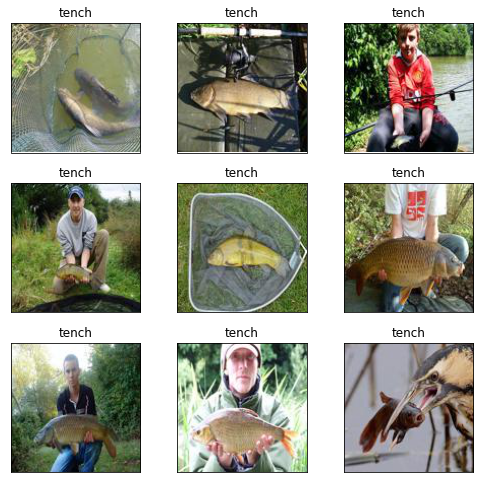

In [7]:
# Display a few train images
train_dataiter = enumerate(trainloader)
_, (train_sample_data, train_sample_targets) = next(train_dataiter)

show_samples(train_sample_data, train_sample_targets)

tensor shape: (1000, 3, 128, 128)

min pixel value: -2.117904
max pixel value: 2.64


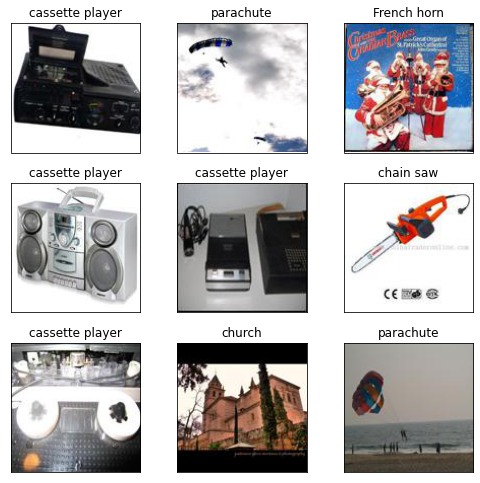

In [8]:
# Display a few test images
test_dataiter = enumerate(testloader)
_, (test_sample_data, test_sample_targets) = next(test_dataiter)

show_samples(test_sample_data, test_sample_targets)

tensor shape: (750, 3, 128, 128)

min pixel value: -2.117904
max pixel value: 2.64


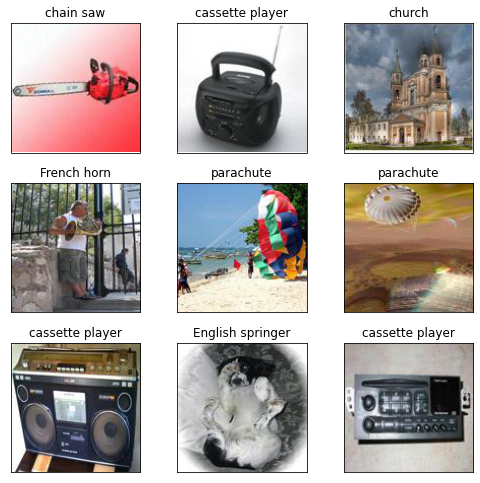

In [9]:
# Display a few calibration images
calib_dataiter = enumerate(calibloader)
_, (calib_sample_data, calib_sample_targets) = next(calib_dataiter)

show_samples(calib_sample_data, calib_sample_targets)

## Prepare Network Architecture

We use the [resnet18](https://arxiv.org/abs/1512.03385) network architecture from the PyTorch package [torchvision](https://pytorch.org/vision/stable/index.html) (see [here](https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html#torchvision.models.resnet18)). However, the architecture was built for the [ImageNet dataset](https://www.image-net.org/). Thus, the architecture has an output size of 1000 which correspond to the 1000 [ImageNet](https://www.image-net.org/) classes. However, [Imagenette](https://github.com/fastai/imagenette) only has 10 classes. Thus, we need to adapt the output layer accordingly.

In [10]:
num_ftrs = arch.fc.in_features
arch.fc = nn.Linear(num_ftrs, num_classes)

print(arch)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [11]:
model_parameters = filter(lambda p: p.requires_grad, arch.parameters())
params = sum([np.prod(p.size()) for p in model_parameters]); 

print("Number of model parameters: {}".format(params))

Number of model parameters: 11181642


## Define Test Functions

In [12]:
def test(model, criterion, dataloader, test_losses, test_accs):
    model.eval()
    correct = 0
    test_loss = 0
    
    with torch.no_grad():
        for data in dataloader:
            # Get the inputs; data is a list of [inputs, labels]
            inputs, targets = data

            if use_cuda:
                inputs, targets = inputs.cuda(), targets.cuda()
            
            # Forward + loss + correct
            outputs = model(inputs)
            test_loss += criterion(outputs, targets).item()
            
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == targets).sum().item()
          
    dataset_size = len(dataloader.dataset)
    test_loss /= dataset_size
    acc = 100. * correct / dataset_size
    
    test_losses.append(test_loss)
    test_accs.append(acc)
    
    print('\nTest set: Avg. loss: {:.6f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, dataset_size, acc
    ))
    
    return test_losses, test_accs

def test_final(model, dataloader, criterion):
    _, accs = test(model, criterion, dataloader, [], [])
    return accs[0]

## Model Testing

In [13]:
# Create Model
model = arch
criterion = nn.CrossEntropyLoss()

# Load Model
model.load_state_dict(
    torch.load(str(model_path)+'.pth', map_location=torch.device('cpu'))
)

<All keys matched successfully>

In [14]:
model.eval()

if use_cuda:
    model.cuda()
    print('Using ', torch.cuda.device_count(), ' GPU(s)')

In [15]:
train_acc = test_final(model, trainloader, criterion)
test_acc = test_final(model, testloader, criterion)
calib_acc = test_final(model, calibloader, criterion)

print('train accuracy: {}'.format(train_acc))
print('test accuracy:  {}'.format(test_acc))
print('calib accuracy: {}'.format(calib_acc))


Test set: Avg. loss: 0.000001, Accuracy: 9468/9469 (99.99%)


Test set: Avg. loss: 0.000845, Accuracy: 2736/3175 (86.17%)


Test set: Avg. loss: 0.000829, Accuracy: 656/750 (87.47%)

train accuracy: 99.98943922272679
test accuracy:  86.1732283464567
calib accuracy: 87.46666666666667


The accuracies are slightly different to the accuracies in the __train_imagenette_128_resnet18.ipynb__ file. The reason for this is that we set the seed value for the generator of the __torch.utils.data.random_split__ function for reproducibility reasons now (we forgot to set it before). As a result, the splitting into test and calibration set seems to be changed slightly. Without seeting this seed the splitting seemed to be reproducible already (probably thought setting __torch.manual_seed__), but we are not completely sure. Thus, we set this generator as well and then save the dataloaders for the test and calibrations set. Then, we can use them for our experiments.

## Store Dataloaders Pth File

To make sure we use the same training, test and calibration set later on we save all corresponding dataloaders.

In [16]:
# Remove old training set pth file and create new one
!rm -f {str(dataloader_path)+'_trainset.pth'}
torch.save(trainloader, str(dataloader_path)+'_trainset.pth') 

# Remove old test set pth file and create new one
!rm -f {str(dataloader_path)+'_testset.pth'}
torch.save(testloader, str(dataloader_path)+'_testset.pth')

# Remove old test set pth file and create new one
!rm -f {str(dataloader_path)+'_calibset.pth'}
torch.save(calibloader, str(dataloader_path)+'_calibset.pth')